In [3]:
# Import related dependent libraries.
import os
from matplotlib import pyplot as plt
import numpy as np
import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms as C
import mindspore.dataset.vision as CV
from mindspore.nn.metrics import Accuracy
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
ms.set_device("CPU")
context.set_context(mode=context.GRAPH_MODE)

In [6]:
# Process data.
def create_dataset(training=True, batch_size=128, resize=(28, 28),
 rescale=1/255, shift=0, buffer_size=64):
 ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
 # Define the resizing, normalization, and channel conversion of the map operation.
 resize_op = CV.Resize(resize)
 rescale_op = CV.Rescale(rescale,shift)
 hwc2chw_op = CV.HWC2CHW()
 # Perform the map operation on the dataset.
 ds = ds.map(input_columns="image", operations=[rescale_op,resize_op, hwc2chw_op])
 ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
 # Set the shuffle parameter and batch size.
 ds = ds.shuffle(buffer_size=buffer_size)
 ds = ds.batch(batch_size, drop_remainder=True)
 return ds

In [7]:
# Read data.
DATA_DIR_TRAIN = "C:/Users/DELL/Documents/HCIA/HCIA-AI V3.5/X-Experiment-Guide/2. Deep Learning and AI Development Framework Lab Guide/MNIST/MNIST/train" # Training set information
DATA_DIR_TEST = "C:/Users/DELL/Documents/HCIA/HCIA-AI V3.5/X-Experiment-Guide/2. Deep Learning and AI Development Framework Lab Guide/MNIST/MNIST/test" # Test set information

# Read data.
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST )

# Display the dataset features.
print('Data volume of the training dataset:',ds_train.get_dataset_size())
print('Data volume of the test dataset:',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('Image length/width/channels:',image['image'].shape)
print('Image label style:',image['label']) # Total 10 label classes which are represented by numbers from 0 to 9.

Data volume of the training dataset: 60000
Data volume of the test dataset: 10000
Image length/width/channels: (28, 28, 1)
Image label style: 7


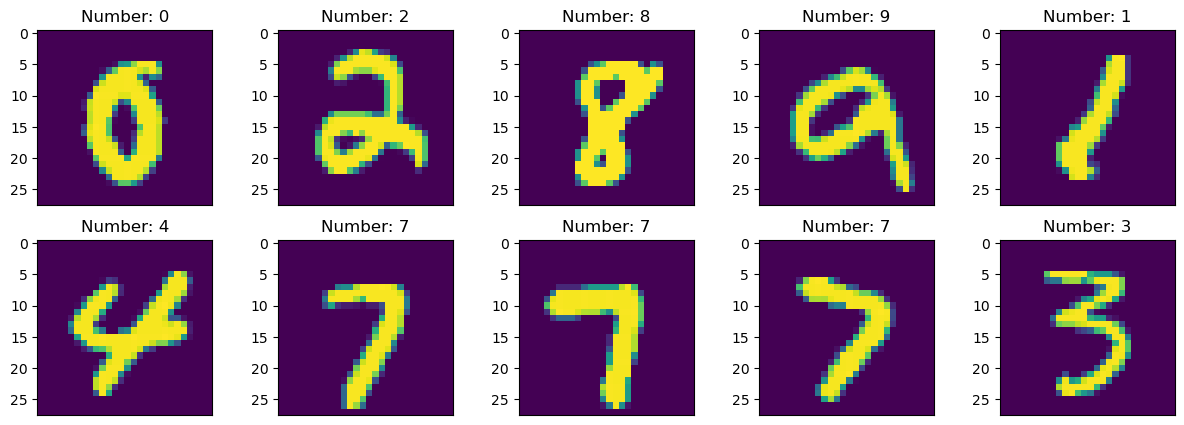

In [8]:
# Display the first 10 images and the labels, and check whether the images are correctly labeled.
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
plt.figure(figsize=(15,5))
for i in range(1,11):
 plt.subplot(2, 5, i)
 plt.imshow(np.squeeze(images[i]))
 plt.title('Number: %s' % labels[i])
 plt.xticks([])
plt.show()

In [9]:
# Define a network.
# Create a model. The model consists of three fully connected layers. The final output layer uses softmax for classification (10 classes consisting of numbers 0 to 9.)
class ForwardNN(nn.Cell):
    def __init__(self):
     super(ForwardNN, self).__init__()
     self.flatten = nn.Flatten()
     self.fc1 = nn.Dense(784, 512, activation='relu')
     self.fc2 = nn.Dense(512, 128, activation='relu')
     self.fc3 = nn.Dense(128, 10, activation=None)


    def construct(self, input_x):
     output = self.flatten(input_x)
     output = self.fc1(output)
     output = self.fc2(output)
     output = self.fc3(output)
     return output

In [12]:
# Define a loss function and an optimizer.
# Create a network, loss function, validation metric, and optimizer, and set related hyperparameters.
lr = 0.0001
num_epoch = 10
momentum = 0.9
net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr)

In [13]:
# Start training.

# Build a model.
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck)

# Generate a dataset.
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)

# Train the model.
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print("============== Starting Training ==============")
model.train(num_epoch, ds_train,callbacks=[ckpoint_cb,loss_cb,time_cb ],dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.6900514364242554
Train epoch time: 6392.407 ms, per step time: 3.409 ms
epoch: 2 step: 1875, loss is 0.19797776639461517
Train epoch time: 6426.426 ms, per step time: 3.427 ms
epoch: 3 step: 1875, loss is 0.14232271909713745
Train epoch time: 6344.297 ms, per step time: 3.384 ms
epoch: 4 step: 1875, loss is 0.24217267334461212
Train epoch time: 14716.402 ms, per step time: 7.849 ms
epoch: 5 step: 1875, loss is 0.07336895912885666
Train epoch time: 16411.772 ms, per step time: 8.753 ms
epoch: 6 step: 1875, loss is 0.018148135393857956
Train epoch time: 16413.723 ms, per step time: 8.754 ms
epoch: 7 step: 1875, loss is 0.07382915914058685
Train epoch time: 16569.261 ms, per step time: 8.837 ms
epoch: 8 step: 1875, loss is 0.010866926982998848
Train epoch time: 17367.671 ms, per step time: 9.263 ms
epoch: 9 step: 1875, loss is 0.005670077167451382
Train epoch time: 16934.016 ms, per step time: 9.031 ms
epoch: 1

In [14]:
# Validate the model.
# Use the test set to validate the model and print the overall accuracy.
metrics=model.eval(ds_eval)
print(metrics)

{'Accuracy': 0.9763621794871795}
